# Reverse sfen Lookup

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'C:\Windows\Fonts\ipaexg.ttf', size=24)

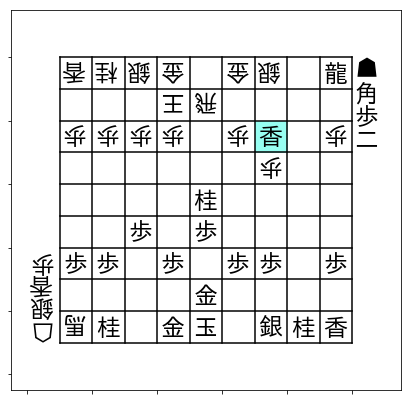

'sfen lnsg1gs1+R/3kr4/pppp1pL1p/6p2/4N4/2P1P4/PP1P1PP1P/4G4/+bN1GK1SNL w B2Pslp 24'

In [97]:

row = ["〇", "一", "二", "三", "四", "五", "六", "七", "八", "九",
          "十", "十一", "十二", "十三", "十四", "十五", "十六", "十七", "十八"]
colmun = ["０", "１", "２", "３", "４", "５", "６", "７", "８", "９"]
# 後手は+1 成りは+2にする
piece = {
    "k": [2**2 + 1, "王"],
    "r": [2**6 + 1, "飛"],
    "+r": [2**6 + 3, "龍"],
    "b": [2**10 + 1, "角"],
    "+b": [2**10 + 3, "馬"],
    "g": [2**14 + 1, "金"],
    "s": [2**18 + 1, "銀"],
    "+s": [2**18 + 3, "全"],
    "n": [2**22 + 1, "桂"],
    "+N": [2**22 + 3, "圭"],
    "l": [2**26 + 1, "香"],
    "+l": [2**26 + 3, "杏"],
    "p": [2**30 + 1, "歩"],
    "+p": [2**30 + 3, "と"],
    "K": [2**2, "玉"],
    "R": [2**6, "飛"],
    "+R": [2**6 + 2, "龍"],
    "B": [2**10, "角"],
    "+B": [2**10 + 2, "馬"],
    "G": [2**14, "金"],
    "S": [2**18, "銀"],
    "+S": [2**18 + 2, "全"],
    "N": [2**22, "桂"],
    "+N": [2**22 + 2, "圭"],
    "L": [2**26, "香"],
    "+L": [2**26 + 2, "杏"],
    "P": [2**30, "歩"],
    "+P": [2**30 + 2, "と"]
}
reverse_piece = {
    2**2 + 1: "k",
    2**6 + 1: "r",
    2**6 + 3: "+r",
    2**10 + 1: "b",
    2**10 + 3: "+b",
    2**14 + 1: "g",
    2**18 + 1: "s",
    2**18 + 3: "+s",
    2**22 + 1: "n",
    2**22 + 3: "+n",
    2**26 + 1: "l",
    2**26 + 3: "+l",
    2**30 + 1: "p",
    2**30 + 3: "+p",
    2**2: "K",
    2**6: "R",
    2**6 + 2: "+R",
    2**10: "B",
    2**10 + 2: "+B",
    2**14: "G",
    2**18: "S",
    2**18 + 2: "+S",
    2**22: "N",
    2**22 + 2: "+N",
    2**26: "L",
    2**26 + 2: "+L",
    2**30: "P",
    2**30 + 2: "+P"
}

def dec_piecenum(piecenum): #駒の数字から駒文字に変更する
    mod = piecenum % 4
    if mod == 0 or mod == 1: # 成り判定
        piece_base = piecenum
        promote = ""
    else:
        piece_base = piecenum - 2 # 成りなら2を引く
        promote = "+"
    return promote + reverse_piece[piece_base]

class Board:
    # コンストラクタ
    def __init__(self, sfen):
        self.ban = np.zeros([9, 9], "int32") # インデックスと符号は1つずれるので注意
        self.set_sfen(sfen)
        
    def __clear_koma(self): # 駒台を空にする
        self.koma = {
            "r": 0,
            "b": 0,
            "g": 0,
            "s": 0,
            "n": 0,
            "l": 0,
            "p": 0,
            "R": 0,
            "B": 0,
            "G": 0,
            "S": 0,
            "N": 0,
            "L": 0,
            "P": 0
        }

    def get_count(self):
        return str(self.count)

    def set_count(self, count=0):
        self.count = int(count)
        return
        
    def get_teban(self): # 手番を返す b(先手) or w(後手)
        return self.teban

    def set_teban(self, new_teban): # 手番を設定、bw以外を与えると手番反転
        if new_teban == "b" or new_teban == "w":
            self.teban = new_teban
        else:
            if self.teban == "b":
                self.teban == "w"
            else:
                self.teban == "b"
                
    def get_sfen_ban(self): # Boardクラスからsfen形式の盤面文字列を生成する
        sfen = ""
        for rank in self.ban: # 1行ずつ処理する
            sfen_rank = ""
            blank_pos = 0
            for pos in rank[::-1]: # 逆順に取り出す
                if pos == 0: # 空マスならカウントを増やす
                    blank_pos += 1
                else:
                    if blank_pos >= 1: # 空マスの分をフラッシュする
                        sfen_rank += str(blank_pos)
                        blank_pos = 0
                    sfen_rank += dec_piecenum(pos)
            if blank_pos >= 1: # 空マスがあればフラッシュする
                sfen_rank += str(blank_pos)
                blank_pos = 0
            sfen += (sfen_rank + "/") # 最後の行にもスラッシュが付与されるがreturnで除かれる
        return sfen[0:-1]

    def set_sfen_ban(self, sfen_ban): # sfen形式の盤面文字列からBoardクラスに値をセットする
        ranks = sfen_ban.split("/") # 1行ずつ分割
        promote_flag = False # Trueなら成り駒
        for i, rank in enumerate(ranks):
            temp_rank = [0, 0, 0, 0, 0, 0, 0, 0, 0]
            temp_itr = 8
            for char in list(rank): # 1行を1文字ずつスキャンする
                if char.isdigit(): # 数字なら空白マスなので飛ばす
                    temp_itr -= int(char)
                elif char == "+": # +のとき
                    promote_flag = True
                else: # 数字でないとき
                    temp_rank[temp_itr] = piece[char][0] # 入力文字を対応する駒の整数にして入れる
                    if promote_flag:
                        temp_rank[temp_itr] += 2 # 成り駒は2を足す
                        promote_flag = False
                    temp_itr -= 1 # sfenは9→1の順なので符号の数字とは逆順になる
            self.ban[i] = temp_rank # 1行ずつ盤面に代入する
        return self.ban

    def __enc_koma_string(self, koma, piece_string):
        num = koma[piece_string]
        if num == 0:
            return ""
        if num == 1:
            return piece_string
        return str(num) + piece_string
    
    def __enc_koma_BODstring(self, koma, piece_string):
        num = koma[piece_string]
        if num == 0:
            return ""
        if num == 1:
            return piece[piece_string][1]
        return piece[piece_string][1] + row[num]

    def get_sfen_koma(self): # Boardクラスからsfen形式の駒台文字列を生成する
        temp = ""
        temp += self.__enc_koma_string(self.koma, "R")
        temp += self.__enc_koma_string(self.koma, "B")
        temp += self.__enc_koma_string(self.koma, "G")
        temp += self.__enc_koma_string(self.koma, "S")
        temp += self.__enc_koma_string(self.koma, "N")
        temp += self.__enc_koma_string(self.koma, "L")
        temp += self.__enc_koma_string(self.koma, "P")
        temp += self.__enc_koma_string(self.koma, "r")
        temp += self.__enc_koma_string(self.koma, "b")
        temp += self.__enc_koma_string(self.koma, "g")
        temp += self.__enc_koma_string(self.koma, "s")
        temp += self.__enc_koma_string(self.koma, "n")
        temp += self.__enc_koma_string(self.koma, "l")
        temp += self.__enc_koma_string(self.koma, "p")
        return temp

    def set_sfen_koma(self, sfen_koma): # sfen形式の駒台文字列からBoardクラスに値をセットする
        self.__clear_koma() # まず駒台を空にする
        if sfen_koma == "-": # ハイフンなら持ち駒なしということ
            return
        num = 0 # 駒数
        for char in list(sfen_koma): # 引数を1文字ずつスキャンする
            if char.isdigit(): # 数字なら
                if num == 0: # 駒数が0なら数字を代入
                    num = int(char)
                else: # 駒数が0でないなら2桁の数字ということ
                    num = 10 * num + int(char)
            else: # 数字でないとき
                if num == 0: # 駒数が0なら1が省略されていたとみなす
                    num = 1
                self.koma[char] = num # 駒台にセットする
                num = 0 # 駒数を0にクリア

    def get_sfen(self): # Boardクラスからsfen文字列を生成する
        return "sfen " + self.get_sfen_ban() + " " + self.get_teban() + " " + self.get_sfen_koma() + " " + self.get_count()

    def set_sfen(self, sfen): # sfen文字列からBoardクラスに値をセットする
        sfen_list = sfen.split(" ") # スペースで分割
        if sfen_list[0] != "sfen":
            print("先頭がsfenではありません。")
            return
        self.set_sfen_ban(sfen_list[1])
        self.set_sfen_koma(sfen_list[3])
        self.set_teban(sfen_list[2])
        self.set_count(sfen_list[4])
    
    def __plot_common(self, plt):
        one = np.ones(9)
        range = np.arange(-9.0, 0.0, 0.1)
        plt.figure(figsize=(7, 7))
        plt.xlim((-10.5, 1.5))
        plt.ylim((-10.5, 1.5))
        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')

        plt.plot([-9.0, 0.0], [-9.0, -9.0], color="#000000")
        plt.plot([-9.0, 0.0], [-8.0, -8.0], color="#000000")
        plt.plot([-9.0, 0.0], [-7.0, -7.0], color="#000000")
        plt.plot([-9.0, 0.0], [-6.0, -6.0], color="#000000")
        plt.plot([-9.0, 0.0], [-5.0, -5.0], color="#000000")
        plt.plot([-9.0, 0.0], [-4.0, -4.0], color="#000000")
        plt.plot([-9.0, 0.0], [-3.0, -3.0], color="#000000")
        plt.plot([-9.0, 0.0], [-2.0, -2.0], color="#000000")
        plt.plot([-9.0, 0.0], [-1.0, -1.0], color="#000000")
        plt.plot([-9.0, 0.0], [-0.0, -0.0], color="#000000")

        plt.plot([-9.0, -9.0], [-9.0, 0.0], color="#000000")
        plt.plot([-8.0, -8.0], [-9.0, 0.0], color="#000000")
        plt.plot([-7.0, -7.0], [-9.0, 0.0], color="#000000")
        plt.plot([-6.0, -6.0], [-9.0, 0.0], color="#000000")
        plt.plot([-5.0, -5.0], [-9.0, 0.0], color="#000000")
        plt.plot([-4.0, -4.0], [-9.0, 0.0], color="#000000")
        plt.plot([-3.0, -3.0], [-9.0, 0.0], color="#000000")
        plt.plot([-2.0, -2.0], [-9.0, 0.0], color="#000000")
        plt.plot([-1.0, -1.0], [-9.0, 0.0], color="#000000")
        plt.plot([-0.0, -0.0], [-9.0, 0.0], color="#000000")

    def __plot_ban(self, plt, kato123=False):
        if kato123: # ひふみんアイでの反転した盤面を作る
            ban = self.ban[::-1]
            for i, rank in enumerate(ban):
                ban[i] = rank[::-1]
        else:
            ban = self.ban
        offset_x = -0.9
        offset_y = -0.8
        for i, rank in enumerate(ban): # 1行ずつ処理する
            for j, pos in enumerate(rank):
                if pos != 0: # 空マス以外なら駒の文字を出力する
                    char = piece[reverse_piece[pos]][1]
                    if kato123:
                        if pos % 2:
                            plt.text(-0.89 - j, -0.75 - i, char, fontsize = 24, rotation = 0, fontproperties=fp)
                        else:
                            plt.text(-0.96 - j, - 0.55 - i, char, fontsize = 24, rotation = 180, fontproperties=fp)
                    else:
                        if pos % 2: # 後手の駒
                            plt.text(-0.96 - j, - 0.55 - i, char, fontsize = 24, rotation = 180, fontproperties=fp)
                        else: # 先手の駒
                            plt.text(-0.89 - j, -0.75 - i, char, fontsize = 24, rotation = 0, fontproperties=fp)
                        
    def __get_koma_b_string(self, koma):
        temp = ""
        temp += self.__enc_koma_BODstring(koma, "R")
        temp += self.__enc_koma_BODstring(koma, "B")
        temp += self.__enc_koma_BODstring(koma, "G")
        temp += self.__enc_koma_BODstring(koma, "S")
        temp += self.__enc_koma_BODstring(koma, "N")
        temp += self.__enc_koma_BODstring(koma, "L")
        temp += self.__enc_koma_BODstring(koma, "P")
        return temp

    def __get_koma_w_string(self, koma):
        temp = ""
        temp += self.__enc_koma_BODstring(koma, "r")
        temp += self.__enc_koma_BODstring(koma, "b")
        temp += self.__enc_koma_BODstring(koma, "g")
        temp += self.__enc_koma_BODstring(koma, "s")
        temp += self.__enc_koma_BODstring(koma, "n")
        temp += self.__enc_koma_BODstring(koma, "l")
        temp += self.__enc_koma_BODstring(koma, "p")
        return temp
    
    def __plot_koma(self, plt, kato123=False):
        if kato123: # ひふみんアイでは駒台が逆になる
            plt.text(0.05, -0.6, "☖", fontsize = 24, rotation = 0, fontproperties=fp)
            plt.text(-10.02, -8.7, "☗", fontsize = 24, rotation = 180, fontproperties=fp)
            for i, char in enumerate(list(self.__get_koma_b_string(self.koma))):
                plt.text(-9.95, -8.0 + 0.7 * i, char, fontsize = 24, rotation = 180, fontproperties=fp)
            for i, char in enumerate(list(self.__get_koma_w_string(self.koma))):
                plt.text(0.05, -1.4 - 0.7 * i, char, fontsize = 24, rotation = 0, fontproperties=fp)
        else:
            plt.text(0.05, -0.6, "☗", fontsize = 24, rotation = 0, fontproperties=fp)
            plt.text(-10.02, -8.7, "☖", fontsize = 24, rotation = 180, fontproperties=fp)
            for i, char in enumerate(list(self.__get_koma_b_string(self.koma))):
                plt.text(0.05, -1.4 - 0.7 * i, char, fontsize = 24, rotation = 0, fontproperties=fp)
            for i, char in enumerate(list(self.__get_koma_w_string(self.koma))):
                plt.text(-9.95, -8.0 + 0.7 * i, char, fontsize = 24, rotation = 180, fontproperties=fp)

    def plot(self, pre=False):
        self.__plot_common(plt)
        self.__plot_ban(plt)
        self.__plot_koma(plt)
        if pre:
            plt.fill_between((-pre[0], -pre[0] + 1), -pre[1], -pre[1] + 1, color='#97fef1')
        plt.show()
    
    def plot123(self, pre=False): # ひふみんアイ
        self.__plot_common(plt)
        self.__plot_ban(plt, True)
        self.__plot_koma(plt, True)
        if pre:
            plt.fill_between((pre[0] - 10, pre[0] - 9), pre[1] - 10, pre[1] - 9, color='#97fef1')
        plt.show()

A = Board(shogi_class['ゴキゲン中飛車']['超急戦']['都成'])
A.plot((3, 3))
A.get_sfen()

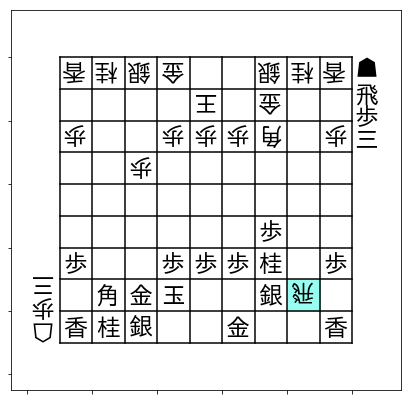

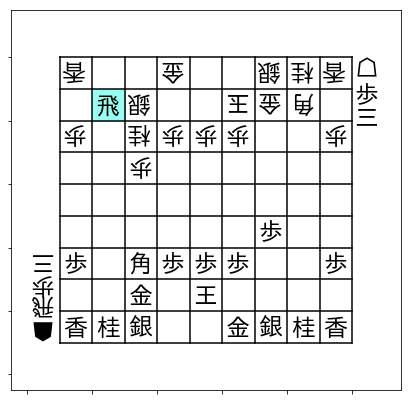

In [98]:
Board("sfen lnsg2snl/4k1g2/p2pppb1p/2p6/9/6P2/P2PPPN1P/1BGK2Sr1/LNS2G2L b R3P3p 10").plot((2, 8))
Board("sfen lnsg2snl/4k1g2/p2pppb1p/2p6/9/6P2/P2PPPN1P/1BGK2Sr1/LNS2G2L b R3P3p 10").plot123((2, 8))

In [59]:
shogi_class['横歩取り']['33角']['勇気']

'sfen lnsgk1snl/6g2/p1ppppb1p/6R2/9/1rP6/P2PPPP1P/1BGK5/LNS2GSNL w 3P2p 18'

In [2]:
black_5 = {
    '一直線穴熊': 'sfen ln3gsnk/1r1s4l/p1pppgbpp/1p3pp2/4P4/2P6/PP1PSPPPP/1B2R2SL/LN1G1G1NK b - 25',
    '54歩64銀': 'ln1g1gsnl/1r3k3/p1pp1p1pp/3sp1p2/1p7/2P1P4/PPSP1PPPP/4R2K1/LN1G1GSNL b Bb 19',
    '55dragon': '55dragon'
}
black_4 = {}
black_3 = {}
black_2 = {
    'ダイレクト': 'direct'
}
white_4 = {}
white_3 = {}
white_2 = {
    'ダイレクト': 'direct',
    '角換わり拒否': 'deny_kakugawari',
    '阪田': 'sakata',
    '鬼殺し': 'onigaroshi',
    'メリケン': 'America'
}
black_fujii = {}
white_fujii = {}
black_kks = {}
white_kks = {}

kondo_fujii = {
    'op': 'sfen lnsgkgsnl/4r4/pppp1p2p/6pR1/9/2P1P4/PP1P1PP1P/1S2G4/LN1GK1SNL w B2Pbp 16',
    '57歩': 'sfen lnsgkgsnl/4r4/pppp1p2p/6pR1/9/2P1P4/PP1PpPP1P/1S2G4/LN1GK1SNL b B2Pb 17',
    '都成': 'sfen lnsg1gs1+R/3kr4/pppp1pL1p/6p2/4N4/2P1P4/PP1P1PP1P/4G4/+bN1GK1SNL w B2Pslp 24',
    '33角': 'sfen lnsg1gs1+R/3kr4/pppp4p/5pp2/4N4/2PLP4/PP1P1PP1P/4G4/+bN1GK1SNL w S2Pblp 28'
}
kondo_hoshino = {
    '銀対抗': 'sfen lnsgkg1nl/4r4/pppp1pbpp/5sp2/4p2P1/2P2SP2/PP1PPP2P/1B1K3R1/LNSG1G1NL b - 17',
    '菅井44歩': 'sfen lnsgkg1nl/4r1s2/pppp2bpp/5pp2/4p2P1/2P3P2/PP1PPPS1P/1B1K3R1/LNSG1G1NL b - 15',
    '72玉': 'sfen lnsg1gsnl/1k2r4/pppp1pbpp/6p2/4p2P1/2P2SP2/PP1PPP2P/1B1K3R1/LNSG1G1NL b - 17'
}
kondo_maruyama = {
    '佐藤': 'sfen lnsgkg1nl/4r2s1/pppp1p1pp/4p1p2/7P1/P1P6/1P1PPPP1P/7R1/LNSGKGSNL w Bb 10'
}
kondo = {
    '超急戦': kondo_fujii,
    '超速': kondo_hoshino,
    '丸山': kondo_maruyama,
    '穴熊': 'anaguma'
}

aifuri = {
    '相三間': 'each3',
    '中飛車左穴熊VS三間飛車': 'black_5left_white_3',
    '角交換四間飛車VS向かい飛車': 'black_kks_white_2',
    'ノーマル四間飛車VS三間飛車': 'black_4_white_3',
    '後手44角型向かい飛車': 'white_44b',
}

aigakari_26r = {
    'op': 'sfen lnsgk1snl/1r4gb1/p1ppppppp/9/1p7/7R1/PPPPPPP1P/1BG6/LNS1KGSNL w P 12',
    '塚田': 'sfen ln1gk1snl/2s3gb1/2p1pppp1/p2p3Pp/9/PrP4RP/3PPPP2/1BG3S2/LNS1KG1NL w Pp 24'
}
aigakari_28r = {
    'op': 'sfen lnsgk1snl/1r4gb1/p1ppppppp/9/1p7/9/PPPPPPP1P/1BG4R1/LNS1KGSNL w P 12'
}
aigakari = {
    'op': 'sfen lnsgk1snl/1r4gb1/p1ppppppp/9/1p5P1/9/PPPPPPP1P/1BG4R1/LNS1KGSNL b - 7',
    '5手': 'sfen lnsgkgsnl/1r5b1/p1ppppp1p/7R1/1p7/9/PPPPPPP1P/1B7/LNSGKGSNL w Pp 8',
    '浮き飛車': aigakari_26r,
    '引き飛車': aigakari_28r
}

yokofu_gosenzo = {
    'op': 'sfen lnsgk1snl/1r4gb1/p1pppp1pp/6pR1/1p7/2P6/PP1PPPP1P/1BG6/LNS1KGSNL b P 13'
}
yokofu_waki = {
    'op': 'sfen lnsgk1s1l/6gb1/p1ppppn1p/6R2/9/1rP6/P2PPPP1P/1BG6/LNS1KGSNL b 3P2p 17'
}
yokofu_each = {
    'op': 'sfen lnsgk1snl/6g2/p1pppp2p/6R2/9/2r6/P2PPPP1P/1SG6/LN2KGSNL b B3Pb3p 19',
    '77桂': 'sfen lnsgk1snl/6g2/p1pppp2p/6R2/9/2r6/P1NPPPP1P/1SG6/L3KGSNL w B3Pb3p 20',
    '羽生の頭脳': 'sfen l+B1gk1snl/2S3g2/p2ppp2p/9/2p6/2K6/P2PPP2P/2G6/LN2+b1G1L b RS2N5Prs2p 1',
    'Ponanza': 'sfen lnsgk1snl/6g2/p1pppp2p/2r6/9/6R2/P1PPPPP1P/1SG6/LN2KGSNL w B2Pb3p 22'
}
yokofu_38p = {
    '44角56角': 'sfen lnsgk1snl/6g2/p1pppp2p/2r2bR2/9/4B4/PPSPPPP1P/2G3S2/LN2KG1NL w 3P2p 1',
    '44角77角決定版': 'sfen lnsgk1snl/4p1g2/p1pp+Bpp1p/4R4/9/2r6/P1NPPPP1P/1S1G2S2/Lb2KG1NL w 5P 1'
}
yokofu_28p = {
    '77角op': 'sfen lnsgk1snl/6g2/p1pppp2p/6R2/9/1rP6/P1BPPPP1P/1SG4p1/LN2KGSNL w 3Pbp 1',
    '77角84飛必勝定跡': 'sfen lnsgk1snl/6g2/p1ppppp1p/1R7/9/7r1/P1BPPPPpP/1SG3G2/LN2K1SNL w 4Pb 1',
    '45角op': 'sfen lnsgk1snl/6g2/p1pppp2p/6R2/5b3/1rP6/P2PPPP1P/1SG4S1/LN2KG1NL b B4Pp 1'
}
yokofu_33b = {
    'op': 'sfen lnsgk1snl/6g2/p1ppppb1p/6R2/9/1rP6/P2PPPP1P/1BG6/LNS1KGSNL b 3P2p 1',
    '竹部': 'sfen lnsgk1snl/6g2/p1pppp+R1p/9/9/1rP6/P2PPPP1P/1BG6/LNS1KGSNL w B3P2p 1',
    '青野': 'sfen lnsgk1snl/6g2/p1ppppb1p/6R2/9/1rP6/P2PPPP1P/1BG1K4/LNS2GSNL w 3P2p 18',
    '勇気': 'sfen lnsgk1snl/6g2/p1ppppb1p/6R2/9/1rP6/P2PPPP1P/1BGK5/LNS2GSNL w 3P2p 18',
    '36飛': 'sfen lnsgk1snl/6g2/p1ppppb1p/9/9/1rP3R2/P2PPPP1P/1BG6/LNS1KGSNL w 3P2p 18',
}
yokofu_naito_52k72s = {
    'op': 'sfen ln1g3nl/2s1k1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K4/LNS2GSNL b 2P2p 25',
    '斎藤15歩': 'sfen ln1g3nl/2s1k1gs1/p1ppppb2/9/4b1P1p/2P4R1/P2PPP2P/1SG1KSG2/LN5NL b R3P2p 37',
    '68玉': 'sfen ln1g3nl/2s1k1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BGK5/LNS2GSNL b 2P2p 25'
}
yokofu_naito_52k_nakahara = {
    '中住まい': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '38銀': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
    '68玉46歩': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P2P1R1/PP1PP1P1P/1BGK1S3/LNS2G1NL w 2P2p 28'
}
yokofu_naito_41k_nakahara = {
    '中住まい': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '38銀': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
    '68玉46歩': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P2P1R1/PP1PP1P1P/1BGK1S3/LNS2G1NL w 2P2p 28'
}
yokofu_naito_52k_nakazumai = {
    '中住まい': 'sfen ln5nl/2gsk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '38銀': 'sfen ln5nl/2gsk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
    '68玉46歩': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P2P1R1/PP1PP1P1P/1BGK1S3/LNS2G1NL w 2P2p 28'
}
yokofu_naito = {
    '豊島アタック': 'sfen lnsg3Bl/3k2gs1/p1ppppn1p/1r7/9/2P4R1/PP1PPPP1P/2G6/LNS1KGSNL w 2Pb2p 26',
    '52玉72銀': yokofu_naito_52k72s,
    '52玉中原': yokofu_naito_52k_nakahara,
    '41玉中原': yokofu_naito_41k_nakahara,
    '中住まい': yokofu_naito_52k_nakazumai
}
yokofu_chuza_41k_nakahara = {
    '中住まい': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/9/1r7/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '新山崎': 'sfen ln2gk1nl/3s2gs1/p2pppb1p/2p6/1r4P2/2P4R1/PP1PPPN1P/1BG2S3/LNS1KG2L w 2P2p 30',
    '58玉中原': 'sfen l3gk1nl/3s2gs1/p1npppb1p/2p6/1r7/2P4R1/PPBPPPP1P/2GSKS3/LN2G2NL w 2P2p 32',
    '69玉中原': 'sfen l3gk1nl/3s2gs1/p1npppb1p/2p6/1r7/2P4R1/PPBPPPP1P/2GS1S3/LN1KG2NL w 2P2p 32'
}
yokofu_chuza_52k_nakahara = {
    '中住まい': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/9/1r7/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '58玉中原': 'sfen l3g2nl/3sk1gs1/p1npppb1p/2p6/1r7/2P4R1/PPBPPPP1P/2GSKS3/LN2G2NL w 2P2p 32',
    '69玉中原': 'sfen l3g2nl/3sk1gs1/p1npppb1p/2p6/1r7/2P4R1/PPBPPPP1P/2GS1S3/LN1KG2NL w 2P2p 32'
}
yokofu_chuza_52k72s = {
    'op': 'sfen ln1g3nl/2s1k1gs1/p1ppppb1p/9/1r7/2P4R1/PP1PPPP1P/1BG1K4/LNS2GSNL b 2P2p 25'
}
yokofu_chuza_52k_nakazumai = {
    '中住まい': 'sfen ln5nl/2gsk1gs1/p1ppppb1p/9/1r7/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28',
    '38銀': 'sfen ln5nl/2gsk1gs1/p1ppppb1p/9/1r7/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27'
}
yokofu_chuza = {
    '41玉中原': yokofu_chuza_41k_nakahara,
    '52玉中原': yokofu_chuza_52k_nakahara,
    '中住まい': yokofu_chuza_52k_nakazumai,
    '52玉72銀': yokofu_chuza_52k72s
}
yokofu = {
    '23歩': yokofu_gosenzo,
    '33桂': yokofu_waki,
    '相横歩': yokofu_each,
    '38歩': yokofu_38p,
    '28歩': yokofu_28p,
    '33角': yokofu_33b,
    '84飛': yokofu_naito,
    '85飛': yokofu_chuza
}

kakugawari_bou = {}
kakugawari_hayakuri = {}
kakugawari_koshikake = {}

kakugawari = {
    '棒銀': kakugawari_bou,
    '早繰り銀': kakugawari_hayakuri,
    '腰掛銀': kakugawari_koshikake
}

kakugawari_tezon = {}

yagura_op = {
    '66歩': 'sfen lnsgkgsnl/1r5b1/p1pppp1pp/1p4p2/9/2PP5/PP2PPPPP/1B1S3R1/LN1GKGSNL w - 6',
    '77銀': 'sfen lnsgkgsnl/1r5b1/p1pppp1pp/1p4p2/9/2P6/PPSPPPPPP/1B5R1/LN1GKGSNL w - 6',
    '新24手組': 'sfen ln3kbnl/1r1sg1g2/p2p2spp/1pp1ppp2/9/2PPP1P2/PPSG1P1PP/2G2S1R1/LNBK3NL b - 25'
}
yagura_kato = {}
yagura_46s37n = {
    '25桂': 'sfen ln5nl/1r4gk1/3psg1p1/1pp1pPpsp/p4S1N1/2PPP+bPPP/PPSG5/1KG3R1L/LN7 w Bp 60',
    '25桂93飛': 'sfen ln4k1l/1r7/r3+Pgn2/1pp1ppppp/p6N1/2P1P1+bPP/PPSG5/1KG2s2L/LN7 b GSPbs2p 83',
    '宮田': 'sfen ln5nl/1r4gk1/2bpsg1p1/1pp1pppsp/p2P5/2P1PSPPP/PPSG1PN2/1KGB2R1L/LN7 w - 46',
    '91手': 'sfen l+R7/6pk1/6gpp/2ppp4/pp5+sl/2P1P4/PPSG1P3/1KG6/LN7 w 2SN2Pr2bg2nl3p 92',
    'Ponanza': 'sfen ln5nl/1r3sgk1/2b2g1pP/2p1ppp2/pp1p3Np/2P1P2P1/PPSG1Ps2/1KGB2R1L/LN7 b S2p 63'
}
yagura_45p = {
    'op': 'sfen ln5nl/1r1s2gk1/3p1gspp/pppbp1p2/5p3/2PPPSPP1/PPSG1P2P/1KGB3R1/LN5NL b - 1'
}
yagura_35p = {
    'op': 'sfen ln3k1nl/1r1sg1g2/p2p2spp/1ppbppp2/6P2/2PPP4/PPSG1P1PP/2G2S2R/LNBK3NL w - 28'
}
yagura_fujii = {
    'op': 'sfen ln5nl/1r1sg1gk1/p2p2spp/2pbppp2/1p5P1/2PPPBP2/PPSG1PS1P/2KG3R1/LN5NL w - 34'
}
yagura_morishita = {
    'op': 'sfen ln3kbnl/1r1s2g2/p2p1gspp/1pp1ppp2/9/2PPP1PP1/PPSG1P2P/2GB1S1R1/LN1K3NL w - 1',
    '47銀同型': 'sfen l6nl/1r3bgk1/p1ns1gspp/2ppppp2/1p5P1/2PPPPP2/PPSG1SN1P/1KGB3R1/LN6L b - 41',
    '棒銀': 'sfen ln5nl/1r3bgk1/3p1gspp/psp1ppp2/1p1P5/2PSP1PP1/PPSG1PN1P/1KGB2R2/LN6L w - 42',
    '雀': '1n3kbnl/r2sg1g2/l2p2spp/1pp1ppp2/p8/2PPP1PP1/PPSG1P2P/1KGB1S1R1/LN5NL b - 33',
    '雀深浦': '1n3kbnl/r2sg1g2/l2p2spp/1pp1ppp2/p3P4/2PP1SP2/PPSG1P1PP/2GB3R1/LNK4NL w - 34'
}
yagura_waki = {
    'op': 'sfen ln5nl/1r4gk1/p1sp1gspp/2pbppp2/1p5P1/2PPPBP2/PPSG1PS1P/1KG4R1/LN5NL b - 37',
    'GPS': 'sfen ln5nl/1r4gk1/p2p1gsp1/1s1bppp1p/1pP4P1/3PP1P1P/PPSG1PS2/1KGB3R1/LN5NL b P 43'
}
yagura_suzume = {}
yagura_nakahara = {}
yagura_yonenaga = {
    'op': 'sfen l4k1nl/1r2g1gb1/p1ns1pspp/2ppp1p2/1p5P1/2PPP1P2/PPSG1P2P/2G2S1R1/LNBK3NL b - 29'
}
yagura_right4 = {}
yagura_yakura = {
    'op': 'sfen ln1g1k1nl/4rsgb1/p2s1p1pp/1pppp1p2/9/2PPP2P1/PPSG1PP1P/1BG2S1R1/LN1K3NL b - 23'
}
yagura_akutsu = {
    'op': 'sfen ln1g1k1nl/1r3sg2/p2psp1pp/2p3p2/1p2b4/2PP3P1/PPSG1PP1P/1BG2S1R1/LN1K3NL b Pp 25',
    '55歩': 'sfen ln1g1k1nl/5sg2/p1bp1p1pp/2rs2p2/1p2p4/3PPB1P1/PPSG1PP1P/2G2S1R1/LN1K3NL b Pp 35',
    '渡辺31玉' : 'sfen ln1g2knl/5sg2/p1bp1p1pp/2rs2p2/1p7/3PPB1P1/PPSG1PP1P/2G2S1R1/LN1K3NL b P2p 35',
    '渡辺33銀' : 'sfen ln1g1k1nl/1r4g2/p2pspspp/2p3p2/1p2b2P1/2PP5/PPSG1PP1P/1BG2S1R1/LN1K3NL b Pp 27'
}
yagura_left_mino = {}
yagura = {
    'op': yagura_op,
    '加藤': yagura_kato,
    '46銀37桂': yagura_46s37n,
    '45歩': yagura_45p,
    '35歩': yagura_35p,
    '藤井': yagura_fujii,
    '森下': yagura_morishita,
    '脇' : yagura_waki,
    '雀': yagura_suzume,
    '中原': yagura_nakahara,
    '米長': yagura_yonenaga,
    '右四間飛車': yagura_right4,
    '矢倉中飛車': yagura_yakura,
    '阿久津': yagura_akutsu,
    '左美濃': yagura_left_mino,
}

other = {
    '嬉野': 'uresino',
    '筋違い角': 'takeichi',
    'カニカニ銀': 'kojima',
    'パックマン': 'packman'
}

test = {
    '羽生 加藤 52銀': 'sfen ln1g5/1r2S1k2/p2pppn2/2ps2p2/1p7/2P6/PPSPPPPLP/2G2K1pr/LN4G1b w BGSLPnp 62',
    '羽生 三浦 86飛': 'sfen l6nl/2B3gk1/p2gp1sp1/5pp1p/6P2/1rP4PP/PpSGP2sR/L8/KNGs3+bL b N4Pnp 69',
    '羽生 渡辺 66銀': 'sfen l7l/g1S6/k1n4pp/ppN3p2/2p4P1/PP1s1bP2/KSNP4P/1G7/L1bS4L b 2RN5P2gp 123',
    '羽生 阿久津 56銀': 'sfen l1r3knl/P2+B1ggPp/1Sn1p2p1/3p2P1P/2n2P2L/pPp1s4/1p1PP4/K1GS1G3/LN5R1 b 2Pbsp 79',
    '谷川 羽生 77桂': 'sfen l6nl/3r1sgk1/2s+B2g2/p4Pp1p/1pp1Sp1p1/P1S1G1PPP/1Pn1P4/1KG6/LN1Rb3L b N3Pp 71',
    '天彦 盤上のシンデレラ54銀':'sfen l5knl/1r2g1g2/p3p2p1/2p1Sp1sp/1p3N3/P1P2P2P/1P2P+p3/2G1G1b2/LNKR4L w BSNPs3p 56',
    '森内 深浦 12銀': 'sfen l3s1+P2/5+r2s/8k/p3P1pR1/9/PSGP3L1/1P5P1/1KG+p+p4/LNG6 b 3N5P2bgsl3p 149',
    '森内 羽生 2枚飛車2枚角': 'sfen lnsg2snl/4k1g2/2pppp1pp/6p2/p8/1GPb2S2/P2RPPP1P/1S5R1/LN2KG1NL w 3Pbp 36',
    '谷川 大山 角不成': 'sfen ln1g2p2/pgks2g2/1p1p3g+R/P1p3B2/N5P2/2P1+pp3/1PSP4P/2K6/LNS3L1L b BSN4Prp 79',
    '杉本 渡辺 角不成変形': 'sfen 1n5nk/4pB3/5p1s1/p2+r2p2/1PP1P2pl/9/P5gsK/3+pg3L/1N5+B1 b R2G2S2L4Pn4p 1'
}
shogi_class = {
    '平手': 'sfen lnsgkgsnl/1r5b1/ppppppppp/9/9/9/PPPPPPPPP/1B5R1/LNSGKGSNL b - 1',
    '先手中飛車': black_5,
    'ゴキゲン中飛車': kondo,
    '先手四間飛車': black_4,
    '後手四間飛車': white_4,
    '先手三間飛車': black_3,
    '後手三間飛車': white_3,
    '先手向かい飛車': black_2,
    '後手向かい飛車': white_2,
    '先手藤井システム': black_fujii,
    '後手藤井システム': white_fujii,
    '先手角交換四間飛車': black_kks,
    '後手角交換四間飛車': white_kks,
    '相振り飛車': aifuri,
    '相掛かり': aigakari,
    '横歩取り': yokofu,
    '角換わり': kakugawari,
    '一手損角換わり': kakugawari_tezon,
    '矢倉': yagura,
    'その他': other,
    'test': test
}

shogi_class['横歩取り']['84飛']

{'41玉中原': {'38銀': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
  '68玉46歩': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P2P1R1/PP1PP1P1P/1BGK1S3/LNS2G1NL w 2P2p 28',
  '中住まい': 'sfen ln2gk1nl/3s2gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28'},
 '52玉72銀': {'68玉': 'sfen ln1g3nl/2s1k1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BGK5/LNS2GSNL b 2P2p 25',
  'op': 'sfen ln1g3nl/2s1k1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K4/LNS2GSNL b 2P2p 25',
  '斎藤15歩': 'sfen ln1g3nl/2s1k1gs1/p1ppppb2/9/4b1P1p/2P4R1/P2PPP2P/1SG1KSG2/LN5NL b R3P2p 37'},
 '52玉中原': {'38銀': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
  '68玉46歩': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P2P1R1/PP1PP1P1P/1BGK1S3/LNS2G1NL w 2P2p 28',
  '中住まい': 'sfen ln2g2nl/3sk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1KSG2/LNS4NL w 2P2p 28'},
 '中住まい': {'38銀': 'sfen ln5nl/2gsk1gs1/p1ppppb1p/1r7/9/2P4R1/PP1PPPP1P/1BG1K1S2/LNS2G1NL b 2P2p 27',
  '68玉46歩': 'sfen ln2g2nl/3sk